# Task #4: find the Wavelenghts!

What is wavelength calibration? Up to now, the extracted spectrum that we have gives the flux as a function of pixel cooordinate in the dispersion direction. We want to convert the pixel values into wavelength values.

Why do we do this calibration? We want to know the wavelength of the radiation that we measure so that we can study the physical processes shaping the observed spectrum and derive information on the astrophysical object where these processes happen. Spectrographs mark the moment in history when astronomy became astrophysics.

How? We will extract a spectrum from the lamp frame, which is an observation made using a source of light emitting at specific known wavelengths. By matching the observed lines in the lamp spectrum with the known emission lines, it is possible to convert pixels into wavelengths.

In [36]:
# Importing all needed packages
# Standard packages for data visualization and modeling
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
%matplotlib notebook

# Packages for reading astronomical data stored in fits files and accessing file paths
from astropy.io import fits  # to read fits files with python
import glob  # to find pathnames

# Packages for importing ad-hoc modules 
import importlib
import sys
#importlib.reload(sys.modules['data_reduction']) # uncomment when you edit the module data_reduction.py
from data_reduction import *

# Other
import datetime
import timeit
from regions import RectanglePixelRegion
from IPython.display import IFrame   # to open and view a pdf in the notebook

Let's first access the lamp frame and verify that it has been bias-subtracted and flat-normalized.

We print below:

-> the pathname of the lamp frame

-> the image type and observation mode

-> the information on the history of the file: has it been bias-subtracted and flat-normalized?

Also, we plot the frame and extract the spectrum using the same aperture window defined in the previous workbook for the science frame. Below you find the plots of the interpolation of the gaussian properties for the continuum tracing and the plot of the extracted spectrum.

# Check lamp frame and extract spectrum 

/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130146_b_f.fits 
Image type: WAVE,LAMP Obs. Mode: SPECTROSCOPY
HISTORY: Master Bias subtracted on 2021-02-19 17:32:48 using master bias file /ho
me/masi1109/Documents/PhD/ObsII/not2mattia/master_bias_mean.fits
Master flat divided on: 2021-02-19 17:33:45 using master flat file /home
/masi1109/Documents/PhD/ObsII/not2mattia/master_flat_mean.fits


<IPython.core.display.Javascript object>


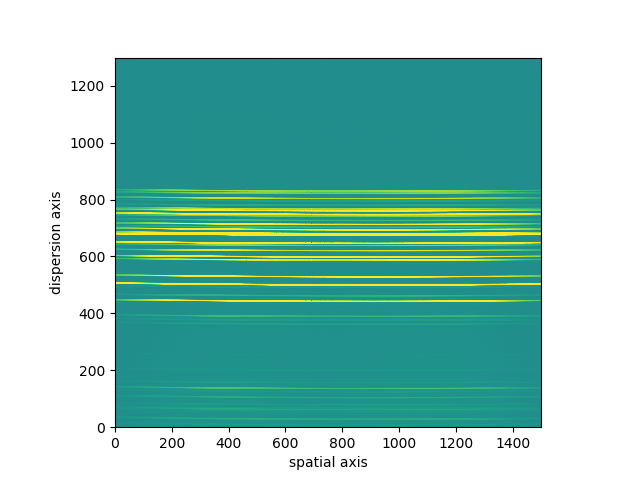

<IPython.core.display.Javascript object>


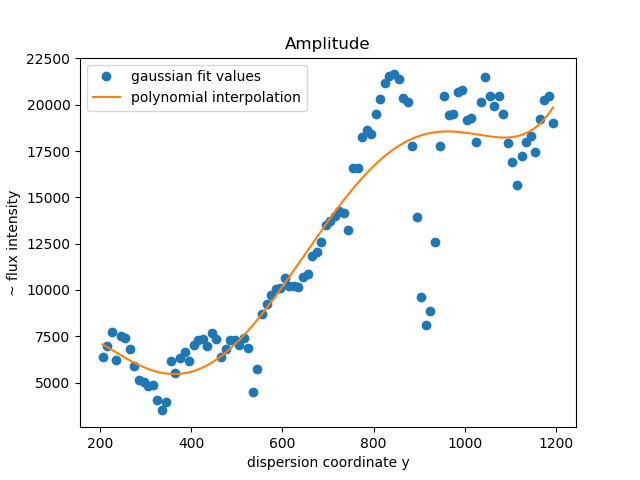

<IPython.core.display.Javascript object>


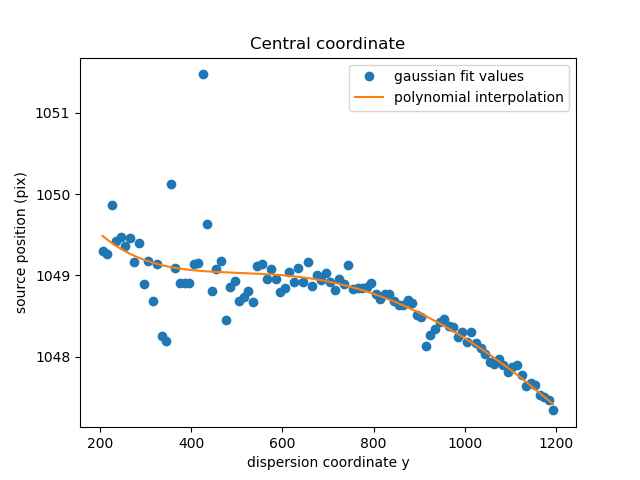

<IPython.core.display.Javascript object>


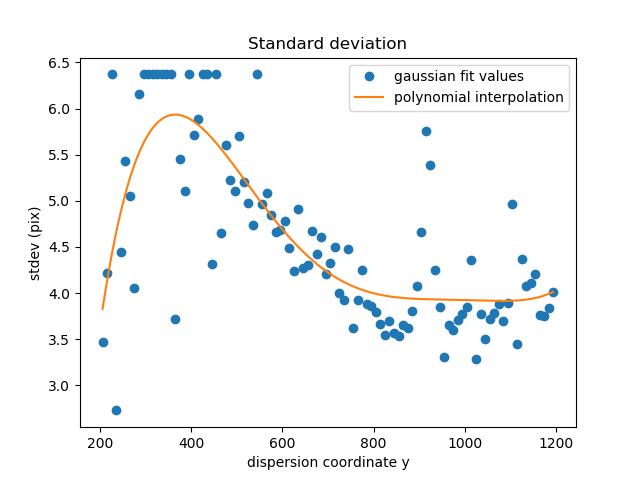

<IPython.core.display.Javascript object>


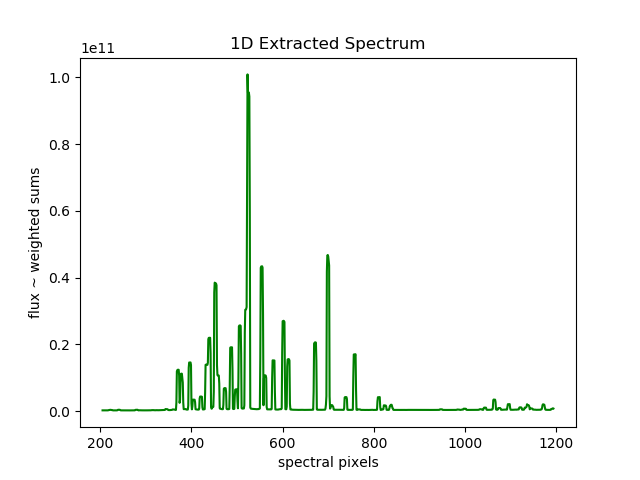

In [37]:
# Directory of the data 
path2data = '/home/masi1109/Documents/PhD/ObsII/not2mattia'
file = path2data + "/ALAe130146_b_f.fits"

hdul = fits.open(file)  # reading the fits file (headers and pixel values)
    
# Region of interest for data calibration
xmin, xmax, ymin, ymax = 300, 1800, 200, 1500 
    
if hdul[0].header['IMAGETYP'] == 'WAVE,LAMP' and hdul[0].header['OBS_MODE'] == 'SPECTROSCOPY':
    print(file, "\nImage type: WAVE,LAMP", "Obs. Mode: SPECTROSCOPY")
        
    # checking bias subtraction and flat normalization
    flat_check = hdul[0].header['HISTORY']
    print("HISTORY:", flat_check)
    
    frame = hdul[1].data
    f = frame[ymin:ymax, xmin:xmax]
    plt.figure()
    plt.imshow(f, origin='lower', vmin=np.median(f)-2*np.std(f), 
                vmax=np.median(f)+2*np.std(f))
    plt.xlabel("spatial axis")
    plt.ylabel("dispersion axis")
    
    # We want to use the same aperture window define in Workbook #3 for extracting the spectrum
    import pickle
    window = pickle.load(open(path2data+"/ALAe130145_window.p", "rb"))
    spec_px, flux = extract_spectrum(frame, window)
    
    # Plotting the spectrum
    plt.figure()
    plt.title("1D Extracted Spectrum")
    plt.plot(spec_px, flux, c='green')
    plt.xlabel("spectral pixels")
    plt.ylabel("flux ~ weighted sums")
        
hdul.close()

# Identify a few lines using the NOT atlas

Now we want to compare the extracted spectrum from the lamp frame with the reference spectrum for the specific grism and lamp used during the observation (which can be read in the header of the lamp frame).

Please open the pdf image of the reference spectrum for a quick visual comparison and make sure that you have extracted from the lamp frame the same spectrum. In particular identify four or five lines and write down their pixel position (in the extracted spectrum) and their wavelengths in the reference spectrum.

Below we do a low-order polynomial fit to the relation pixel-wavelength and plot it. The fit represents an approximation of the dispersion relation, which is our ultimate goal.

<IPython.core.display.Javascript object>


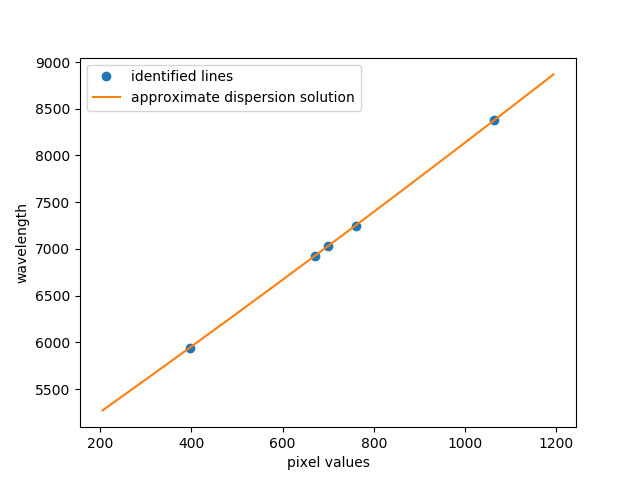

In [38]:
# For start, identify a few lines referring to the NOT line atlas of the correct grism and lamp
# please find this at http://www.not.iac.es/instruments/alfosc/lamps/
atlas_name = '/home/masi1109/Documents/PhD/ObsII/map-g04-ne-1.pdf'
IFrame(atlas_name, width=512, height=512) 

# Write down the pixel values of the lines in the extracted spectrumm 
# and the corresponding wavelength in the atlas

p0, p1, p2, p3, p4 = 397, 670, 700, 760, 1064
w0, w1, w2, w3, w4 = 5944.8342, 6929.468, 7032.4127, 7245.1670, 8377.6070

# Fit a low-order polynomial to get an approximate dispersion relation
# that can be used to ocnvert wavelengths in Å to pixel values
xs = [p0, p1, p2, p3, p4]
ys = [w0, w1, w2, w3, w4]
quadratic_fit = np.polyfit(xs, ys, 2)
disp_sol = np.polyval(quadratic_fit, spec_px)
from_lam_to_pix = sp.interpolate.interp1d(disp_sol, spec_px, fill_value='extrapolate')

plt.figure()
plt.plot(xs, ys, 'o', label='identified lines')
plt.plot(spec_px, disp_sol, label='approximate dispersion solution')
plt.xlabel("pixel values")
plt.ylabel("wavelength")
plt.legend()

# Choose more lines to find true dispersion relation

Now that we have an approximate dispersion relation, we can read the list of emission lines and their wavelengths that we expect to be looking at in the extracted lamp spectrum. 

We plot these lines as narrow gaussians on top of the extracted lamp spectrum. Please stretch it vertically in order to display the whole legend. 

<IPython.core.display.Javascript object>


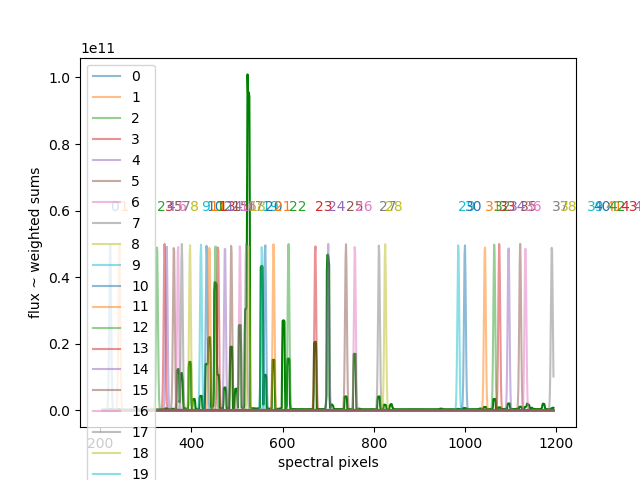

In [39]:
# Get access to the IRAF list (fits file of the lamp frame says He and Ne lamps are on)
list_file = "line_atlas/IRAF_arclamp_linelist_Ne.txt"
lam = np.loadtxt(list_file, usecols=[0])

# Plot lines in the list on top of the extracted spectrum
pix = from_lam_to_pix(lam)

plt.figure()
plt.plot(spec_px, flux, c='green')
plt.xlabel("spectral pixels")
plt.ylabel("flux ~ weighted sums")

for i in range(len(pix)):
    sigma = 2
    g_init = models.Gaussian1D(amplitude=5e10, mean=pix[i], stddev=sigma)
    p = plt.plot(spec_px, g_init(spec_px), alpha=0.5, label=str(i))
    # For color-blind people? Plot label (number) on top of each gaussian
    plt.text(pix[i], 6e10, str(i), c=p[0].get_color())
    plt.legend(loc='upper left')

The plotted gaussian should match with the lines of the lamp spectrum. 
Please choose below around 20 lines that are well detected in the lamp spectrum. 
We will use those for fitting the true dispersion relation.

But first, we will find the exact centroids (in pixel coordinate) of the chosen lines by fitting them one by one with narrow gaussians. 
After this, we perform a linear regression and plot the true dispersion relation found.

Finally we evaluate and plot the residuals of the regression and print the root mean squared in wavelength domain.

<IPython.core.display.Javascript object>


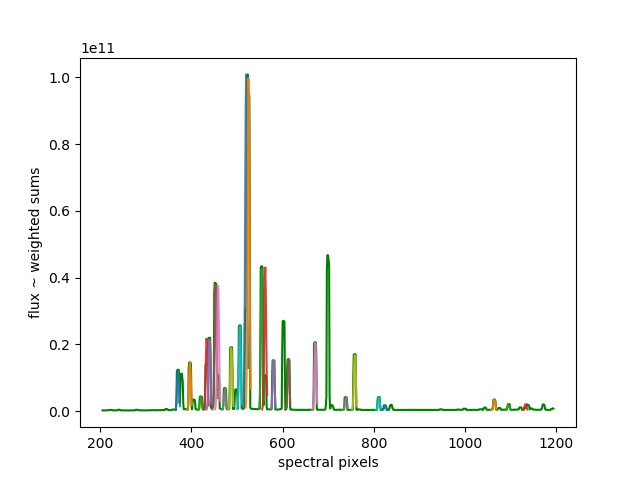

<IPython.core.display.Javascript object>


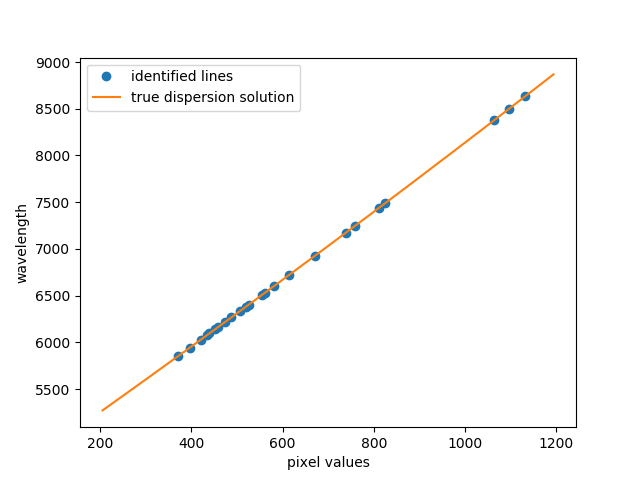

<IPython.core.display.Javascript object>


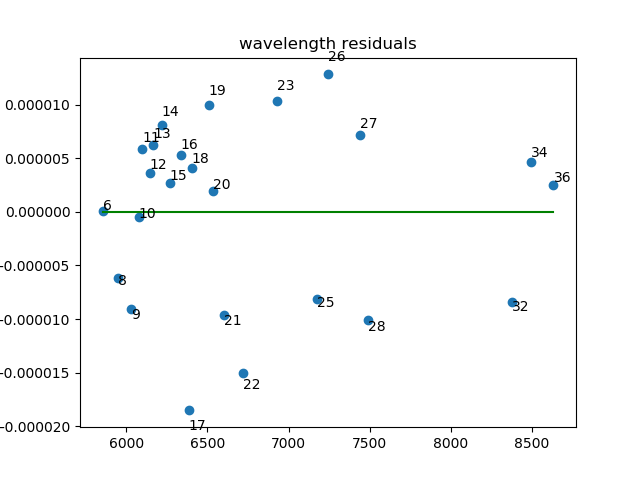

wavelength rms = 8.360328953317288e-06

NB When you run twice the cell above, you will get a funky output.Run all cells of the workbook at once to be on the safe side


In [40]:
# Write the lines number of the chosen line to find the true dispersion solution (~20) 
# elongate the plot below vertically to display fully the legend and zoom into the line

chosen_lines = [6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,32,34,36]

# Find exact centroids of the chosen lines
# by fitting the emission lines one by one taking as initial guesses the values in the lam array
cen_pix = []
cen_lam = []
plt.figure()    
plt.plot(spec_px, flux, c="green")
plt.xlabel("spectral pixels")
plt.ylabel("flux ~ weighted sums")

for j in chosen_lines:
    sigma = 2
    # Interval where to fit the emission line:
    xfit_min = int(pix[j]-3*sigma) - spec_px.min()
    xfit_max = int(pix[j]+3*sigma) - spec_px.min()
    xfit = np.arange(xfit_min, xfit_max)
    const = 3.5e8  # continuum level of the arc lamp (check above!)
    amp = flux[xfit].max() - const
    
    g_init = models.Gaussian1D(amplitude=amp, mean=pix[j], stddev=sigma,   
                           bounds={"stddev" : [1, 5], "amplitude" : [1e9, 2e11]})
    fit_g = fitting.LevMarLSQFitter()
    g = fit_g(g_init, xfit, flux[xfit_min:xfit_max] - const)
    plt.plot(spec_px[xfit], g(spec_px[xfit])+const, alpha=0.9)
    
    cen_pix.append(g.mean[0])
    cen_lam.append(lam[j])

# Linear Regression centroids (pixels) vs central wavelenghts
real_fit = np.polyfit(cen_pix, cen_lam, 2)
real_sol = np.polyval(real_fit, spec_px)
from_pix_to_lam = sp.interpolate.interp1d(spec_px, real_sol, fill_value='extrapolate')

plt.figure()  # plotting the true dispersion relation
plt.plot(cen_pix, cen_lam, 'o', label='identified lines')
plt.plot(spec_px, real_sol, label='true dispersion solution')
plt.xlabel("pixel values")
plt.ylabel("wavelength")
plt.legend()


# Goodness of fit
fit_lam = np.polyval(real_fit, cen_pix)
N = len(cen_pix)
lam_rms = np.sqrt ( sum ( (fit_lam - cen_lam)**2 ) / N)

plt.figure()  # plotting the residuals of the linear regression
plt.title('wavelength residuals')
plt.plot(cen_lam, (cen_lam - fit_lam), 'o')
plt.plot(cen_lam, np.zeros(len(cen_lam)), c='green')
for i,j in zip(chosen_lines, range(len(cen_lam))):
    plt.text(cen_lam[j], 1.1*(cen_lam[j] - fit_lam[j]), str(i))
    
print("wavelength rms = " + str(lam_rms))
print("\nNB When you run twice the cell above, you will get a funky output.\
Run all cells of the workbook at once to be on the safe side")

# Calibrate the science spectrum and save it

Once we have a dispersion relation to convert pixels into wavelengths, we can import the uncalibrated science spectrum extracted in the previous workbook and calibrate its wavelength axis!

We plot below the wavelength-calibrated spectrum and save it as a text file in our data directory.

<IPython.core.display.Javascript object>


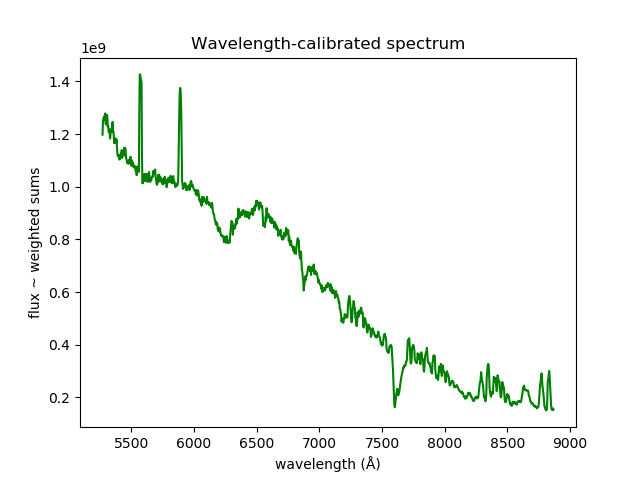

In [41]:
# Import the uncalibrated science spectrum
pix, fpix = np.loadtxt(path2data+"/ALAe130145_1dSpectrum.txt", unpack=True)
wav = from_pix_to_lam(pix)  # array of wavelengths
plt.figure()
plt.plot(wav, fpix, c="green")
plt.title("Wavelength-calibrated spectrum")
plt.xlabel("wavelength (Å)")
plt.ylabel("flux ~ weighted sums")
plt.savefig("figs/SN_spectrum_wav-cal.pdf")

# Saving the calibrated spectrum in a text file
file_out = open(path2data+"/ALAe130145_1dSpectrum_wav-cal.txt", "w")
file_out.write("# 1d spectrum optimally extracted from frame ALAe130145_b_f.fits\n")
file_out.write('# Wavelength calibrated')
file_out.write("# Column 1: wavelength (Å)    Column 2: flux (uncalibrated)\n")

for i in range(len(pix)):
    s = '{:.4f}    {:.4f}\n'.format(wav[i], fpix[i])
    file_out.write(s)
    
file_out.close()